In [0]:
pip install eurostat

  Obtaining dependency information for eurostat from https://files.pythonhosted.org/packages/51/a0/51b4254341558a69002100e1bc9df436c000e03a1ae3488b7e431c61b890/eurostat-1.1.1-py3-none-any.whl.metadata
Note: you may need to restart the kernel using %restart_python or dbutils.library.restartPython() to use updated packages.


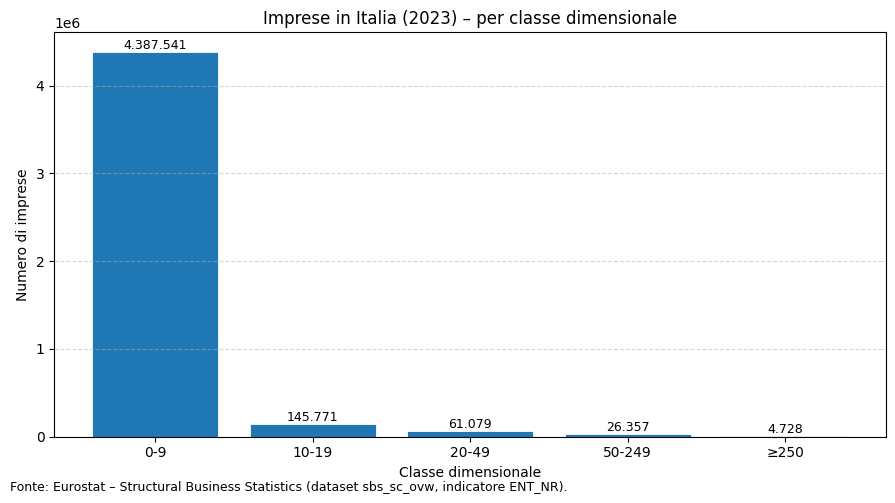

In [0]:
# -*- coding: utf-8 -*-
import eurostat
import pandas as pd
import matplotlib.pyplot as plt

# Parametri
DATASET = "sbs_sc_ovw"
GEO_COL = "geo\\TIME_PERIOD"
NACE_TOTAL = "B-S_X_O_S94"
YEAR = "2023"
SIZE_ORDER = ["0-9", "10-19", "20-49", "50-249", "GE250"]

# 1) Dati Eurostat
df = eurostat.get_data_df(DATASET)

# 2) Filtro Italia, totale economia, indicatore numero imprese
f = (
    (df[GEO_COL] == "IT") &
    (df["nace_r2"] == NACE_TOTAL) &
    (df["indic_sbs"] == "ENT_NR") &
    (df["size_emp"].isin(SIZE_ORDER))
)
it = df.loc[f, ["size_emp", YEAR]].copy()
it[YEAR] = pd.to_numeric(it[YEAR], errors="coerce")
it["size_emp"] = pd.Categorical(it["size_emp"], categories=SIZE_ORDER, ordered=True)
it = it.sort_values("size_emp").set_index("size_emp")

# 3) Rinomina GE250 -> ≥250
it = it.rename(index={"GE250": "≥250"})

# 4) Grafico con barre blu
fig, ax = plt.subplots(figsize=(9,5))
bars = ax.bar(it.index, it[YEAR].values, color="#1f77b4", edgecolor="white", linewidth=0.6)

# Etichette sopra le barre
for b, v in zip(bars, it[YEAR].values):
    label = f"{int(round(v)):,}".replace(",", ".")
    ax.text(b.get_x() + b.get_width()/2, b.get_height(),
            label, ha="center", va="bottom", fontsize=9)

ax.set_title("Imprese in Italia (2023) – per classe dimensionale")
ax.set_xlabel("Classe dimensionale")
ax.set_ylabel("Numero di imprese")
ax.grid(axis="y", linestyle="--", alpha=0.5)
fig.tight_layout()
fig.text(0.01, 0.01,
         "Fonte: Eurostat – Structural Business Statistics (dataset sbs_sc_ovw, indicatore ENT_NR).",
         ha="left", fontsize=9)

plt.show()


Anno scelto: 2023


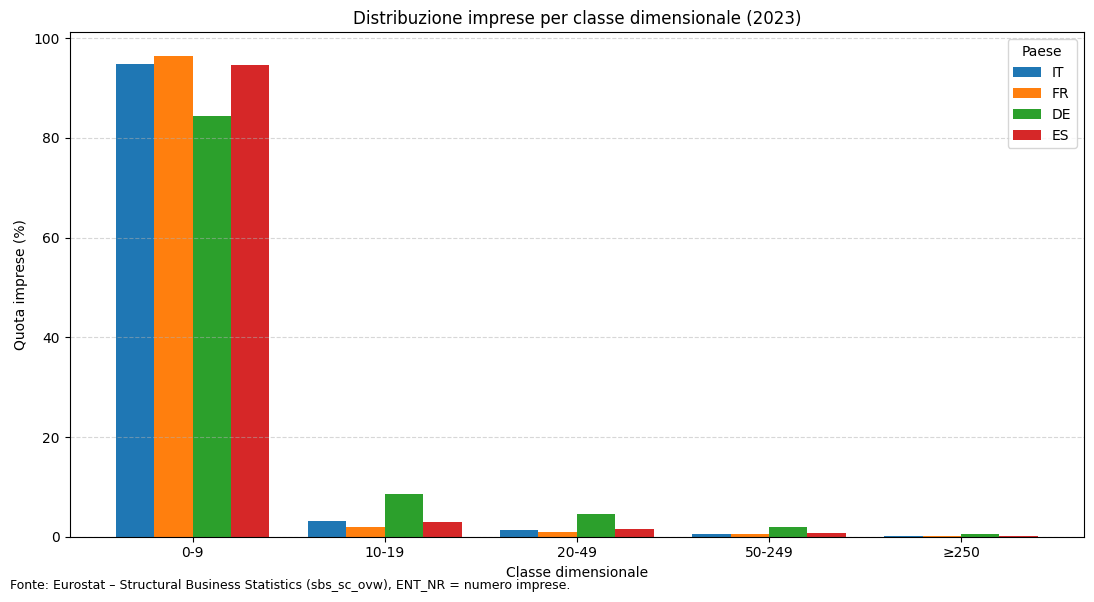

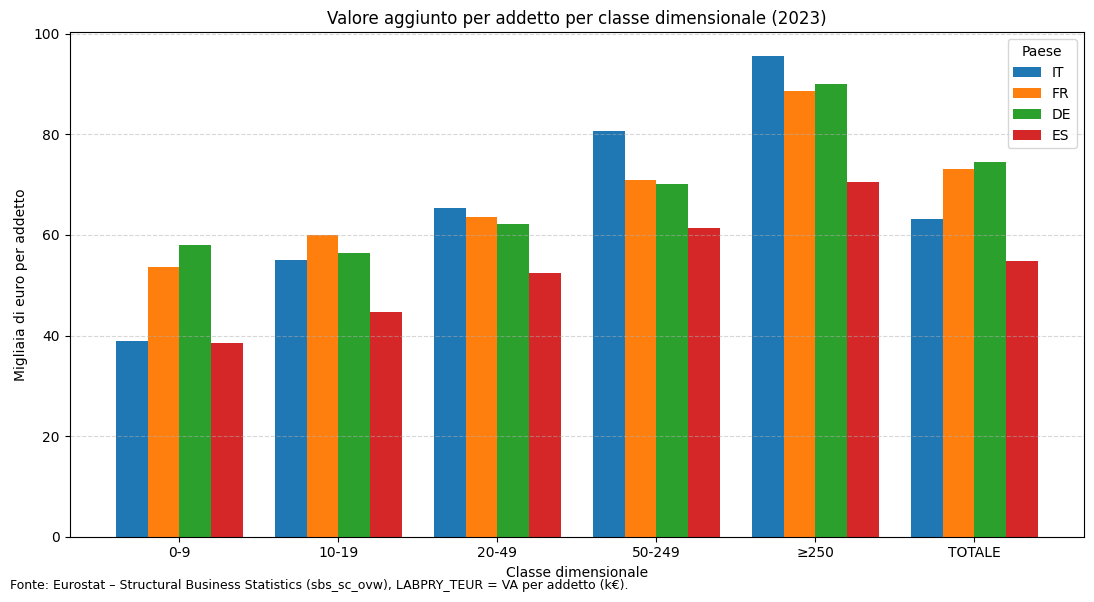

In [0]:
import eurostat
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

DATASET = "sbs_sc_ovw"
countries = ["IT", "FR", "DE", "ES"] 
# ordine con TOTAL in fondo e GE250 rinominato
size_order = ["0-9", "10-19", "20-49", "50-249", "GE250", "TOTAL"]
geo_col = "geo\\TIME_PERIOD"
nace_total = "B-S_X_O_S94"

IND_ENT = "ENT_NR"        # numero imprese
IND_LAB = "LABPRY_TEUR"   # VA per addetto (k€)

df = eurostat.get_data_df(DATASET)
year_cols = [c for c in df.columns if c.isdigit() and len(c) == 4]
year_cols.sort()

base = df[
    (df[geo_col].isin(countries)) &
    (df["nace_r2"] == nace_total) &
    (df["size_emp"].isin(size_order))
].copy()

def last_common_year(base, ind_codes):
    years = list(reversed(year_cols))
    for y in years:
        ok = True
        for ind in ind_codes:
            z = base[base["indic_sbs"] == ind]
            need = len(countries) * len(size_order)
            have = z[y].notna().sum()
            if have < need:
                ok = False
                break
        if ok:
            return y
    raise ValueError("Nessun anno completo.")

year = last_common_year(base, [IND_ENT, IND_LAB])
print("Anno scelto:", year)

def make_pivot(ind):
    z = base[base["indic_sbs"] == ind].copy()
    z[year] = pd.to_numeric(z[year], errors="coerce")
    z["size_emp"] = pd.Categorical(z["size_emp"], categories=size_order, ordered=True)
    p = z.pivot(index="size_emp", columns=geo_col, values=year).loc[size_order, countries]
    # rinomina GE250
    p = p.rename(index={"GE250": "≥250"})
    return p

pivot_ent = make_pivot(IND_ENT)
pivot_lab = make_pivot(IND_LAB)

# quote % per paese (senza TOTAL, che rimane assoluto)
pivot_ent_share = pivot_ent.drop(index="TOTAL")
pivot_ent_share = pivot_ent_share.div(
    pivot_ent_share.loc[["0-9","10-19","20-49","50-249","≥250"]].sum(axis=0), axis=1
) * 100

# rinomina TOTAL in TOTALE nel secondo pivot
pivot_lab = pivot_lab.rename(index={"TOTAL": "TOTALE"})

def grouped_bars(pivot_df, ylabel, title, note):
    X = np.arange(len(pivot_df.index))
    m = len(pivot_df.columns)
    width = 0.8 / m

    fig, ax = plt.subplots(figsize=(11, 6))
    for j, col in enumerate(pivot_df.columns):
        ax.bar(X + (j - (m-1)/2)*width, pivot_df[col].values, width, label=col)

    ax.set_xticks(X)
    ax.set_xticklabels(pivot_df.index)
    ax.set_ylabel(ylabel)
    ax.set_xlabel("Classe dimensionale")
    ax.set_title(f"{title} ({year})")
    ax.grid(axis="y", linestyle="--", alpha=0.5)
    ax.legend(title="Paese")
    fig.tight_layout()
    fig.text(0.01, 0.01, note, ha="left", fontsize=9)
    plt.show()

# Grafici
grouped_bars(
    pivot_ent_share,
    ylabel="Quota imprese (%)",
    title="Distribuzione imprese per classe dimensionale",
    note="Fonte: Eurostat – Structural Business Statistics (sbs_sc_ovw), ENT_NR = numero imprese."
)

grouped_bars(
    pivot_lab,
    ylabel="Migliaia di euro per addetto",
    title="Valore aggiunto per addetto per classe dimensionale",
    note="Fonte: Eurostat – Structural Business Statistics (sbs_sc_ovw), LABPRY_TEUR = VA per addetto (k€)."
)
